### 1. Load Libraries 

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
PATH = '/mnt/project/grp_202/khan74/i3d_keras/tmp'

import sys
sys.path.append(PATH+'/../')
sys.path.append(PATH+'/../src/')

In [3]:
PATH = '/mnt/project/grp_202/khan74/i3d_keras/'

In [4]:
from __future__ import print_function
from __future__ import absolute_import

import warnings

import numpy as np

from keras.models import Model
from keras import layers
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv3D
from keras.layers import MaxPooling3D
from keras.layers import AveragePooling3D
from keras.layers import Dropout
from keras.layers import Reshape
from keras.layers import Lambda
from keras.layers import GlobalAveragePooling3D

from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K

from keras import optimizers
import keras

Using TensorFlow backend.


In [5]:
import matplotlib.pyplot as plt
import seaborn as sn
from ipywidgets import *
import cv2

In [6]:
from i3d_inception import Inception_Inflated3d

In [7]:
# Animate

#@title Import the necessary modules
# TensorFlow and TF-Hub modules.
from absl import logging

#import tensorflow as tf
#import tensorflow_hub as hub

logging.set_verbosity(logging.ERROR)

# Some modules to help with reading the UCF101 dataset.
import random
import re
import os
import tempfile
import cv2
import numpy as np

# Some modules to display an animation using imageio.
import imageio
from IPython import display

from urllib import request  # requires python3

In [8]:
# Utilities to open video files using CV2
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]


def load_video(path, max_frames=0, resize=(224, 224)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames) / 255.0

def animate(images):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images, fps=25)
    with open('./animation.gif','rb') as f:
        display.display(display.Image(data=f.read(), height=300))

In [9]:
def show_rgb(video_path_npy):
    rgb = np.load(video_path_npy)
    rgb = (rgb + 1) / 2
    #rgb = np.squeeze(rgb, axis=0)  # remove the batch dimension
    nb_frames = rgb.shape[0]

    for i in range(0, nb_frames):
        rgb_1st_img = rgb[i, :, :, :]
        cv2.imshow('img_flow', rgb_1st_img)
        cv2.waitKey(0)

In [10]:
def conv3d_bn(x,
              filters,
              num_frames,
              num_row,
              num_col,
              padding='same',
              strides=(1, 1, 1),
              use_bias = False,
              use_activation_fn = True,
              use_bn = True,
              name=None):
    """Utility function to apply conv3d + BN.

    # Arguments
        x: input tensor.
        filters: filters in `Conv3D`.
        num_frames: frames (time depth) of the convolution kernel.
        num_row: height of the convolution kernel.
        num_col: width of the convolution kernel.
        padding: padding mode in `Conv3D`.
        strides: strides in `Conv3D`.
        use_bias: use bias or not  
        use_activation_fn: use an activation function or not.
        use_bn: use batch normalization or not.
        name: name of the ops; will become `name + '_conv'`
            for the convolution and `name + '_bn'` for the
            batch norm layer.

    # Returns
        Output tensor after applying `Conv3D` and `BatchNormalization`.
    """
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None

    x = Conv3D(
        filters, (num_frames, num_row, num_col),
        strides=strides,
        padding=padding,
        use_bias=use_bias,
        name=conv_name)(x)

    if use_bn:
        if K.image_data_format() == 'channels_first':
            bn_axis = 1
        else:
            bn_axis = 4
        x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)

    if use_activation_fn:
        x = Activation('relu', name=name)(x)

    return x

### 2. Load Model 

In [11]:
FRAME_HEIGHT = 224
FRAME_WIDTH = 224
NUM_RGB_CHANNELS = 3
NUM_FLOW_CHANNELS = 2

NUM_CLASSES = 2

#LABEL_MAP_PATH = PATH+'data/label_map.txt'

In [12]:
rgb_sample = np.load(PATH + '/data/fall_no_fall/HS_data/processed_dataset_win20_thre18/fall/10229.npy')
rgb_sample = np.expand_dims(rgb_sample, axis=0)
INPUT_SHAPE = rgb_sample.shape[1]; INPUT_SHAPE

20

In [13]:
rgb_model = Inception_Inflated3d(
                include_top=False,
                weights='rgb_imagenet_and_kinetics',
                input_shape=(INPUT_SHAPE, FRAME_HEIGHT, FRAME_WIDTH, NUM_RGB_CHANNELS),
                classes=NUM_CLASSES)

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
x = rgb_model.output
#x = AveragePooling3D((2, 7, 7), strides=(1, 1, 1), padding='valid', name='global_avg_pool')(x)
x = Dropout(0.5)(x)

x = conv3d_bn(x, NUM_CLASSES, 1, 1, 1, padding='same', 
        use_bias=True, use_activation_fn=False, use_bn=False, name='Conv3d_6a_1x1')

num_frames_remaining = int(x.shape[1])
x = Reshape((num_frames_remaining, NUM_CLASSES))(x)

# logits (raw scores for each class)
x = Lambda(lambda x: K.mean(x, axis=1, keepdims=False),
           output_shape=lambda s: (s[0], s[2]))(x)

x = Activation('softmax', name='prediction')(x)

model = Model(rgb_model.input, x, name='i3d_inception')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
model.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(lr=0.0001), metrics=["accuracy"])

In [16]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20, 224, 224, 0                                            
__________________________________________________________________________________________________
Conv3d_1a_7x7_conv (Conv3D)     (None, 10, 112, 112, 65856       input_1[0][0]                    
__________________________________________________________________________________________________
Conv3d_1a_7x7_bn (BatchNormaliz (None, 10, 112, 112, 192         Conv3d_1a_7x7_conv[0][0]         
__________________________________________________________________________________________________
Conv3d_1a_7x7 (Activation)      (None, 10, 112, 112, 0           Conv3d_1a_7x7_bn[0][0]           
__________________________________________________________________________________________________
MaxPool2d_

### Load Data  + Train

In [17]:
# data_path = '/home/khan74/project/i3d_keras/data/fall_no_fall/HS_data/processed_dataset_win20_thre15/'
# data_path = '/home/khan74/project/i3d_keras/data/fall_no_fall/HS_data/processed_dataset_win20_thre18_2/'

data_path = '/home/khan74/project/i3d_keras/data/fall_no_fall/HS_data/processed_dataset_win20_thre18_3/'

In [18]:
import glob

train_falls = []
for file in glob.glob(data_path+"train/fall/*.npy"):
    train_falls.append(file)
    

train_no_falls = []
for file in glob.glob(data_path+"train/nofall/*.npy"):
    train_no_falls.append(file)
    
test_falls = []
for file in glob.glob(data_path+"test/fall/*.npy"):
    test_falls.append(file)
    

test_no_falls = []
for file in glob.glob(data_path+"test/nofall/*.npy"):
    test_no_falls.append(file)

In [19]:
print(len(train_falls)); print(len(train_no_falls)); print(len(test_falls)); print(len(test_no_falls))

47
159
11
56


In [20]:
x_train, y_train = [], []

for f in train_falls:
    rgb_sample = np.load(f)
    x_train.append(rgb_sample)
    y_train.append(1)
    

for f in train_no_falls:
    rgb_sample = np.load(f)
    x_train.append(rgb_sample)
    y_train.append(0)

In [21]:
x_test, y_test = [], []

for f in test_falls:
    rgb_sample = np.load(f)
    x_test.append(rgb_sample)
    y_test.append(1)
    

for f in test_no_falls:
    rgb_sample = np.load(f)
    x_test.append(rgb_sample)
    y_test.append(0)

In [22]:
x_train = np.array(x_train); x_train = x_train/255
y_train = np.array(y_train); y_train = keras.utils.to_categorical(y_train, 2)

x_test = np.array(x_test); x_test = x_test/255
y_test = np.array(y_test); y_test = keras.utils.to_categorical(y_test, 2)

In [23]:
hist = model.fit(x=x_train, y=y_train, batch_size=16, epochs=10, shuffle=True, validation_data=(x_test, y_test))#validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 206 samples, validate on 67 samples
Epoch 1/10
206/206 [==============================] - 32s 153ms/step - loss: 0.4731 - acc: 0.8058 - val_loss: 0.3418 - val_acc: 0.8955
Epoch 2/10
206/206 [==============================] - 9s 45ms/step - loss: 0.2277 - acc: 0.9660 - val_loss: 0.2276 - val_acc: 0.9254
Epoch 3/10
206/206 [==============================] - 10s 46ms/step - loss: 0.1615 - acc: 0.9660 - val_loss: 0.1848 - val_acc: 0.9254
Epoch 4/10
206/206 [==============================] - 9s 45ms/step - loss: 0.0884 - acc: 1.0000 - val_loss: 0.1725 - val_acc: 0.9254
Epoch 5/10
206/206 [==============================] - 9s 45ms/step - loss: 0.0597 - acc: 1.0000 - val_loss: 0.1583 - val_acc: 0.9254
Epoch 6/10
206/206 [==============================] - 9s 43ms/step - loss: 0.0459 - acc: 1.0000 - val_loss: 0.1499 - val_acc: 0.9403
Epoch 7/10
206/206 [==============================] - 9s 45ms/step - loss: 0.0283 - acc: 1.0000 - val_loss

In [24]:
model.save_weights('train_2.h5')

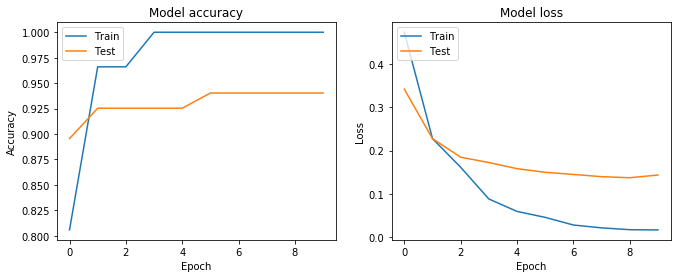

In [25]:
#Training Accuracy/Loss

plt.figure( figsize=(11,4) )

# Plot training & validation accuracy values
plt.subplot(1,2,1)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Predict

###### cf matrix

In [26]:
import itertools
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from inspect import signature

In [27]:
def plot_prec_recall_curve(Predictions, Actuals):
    precision, recall, _ = precision_recall_curve(Actuals, Predictions)
    average_precision = average_precision_score(Actuals, Predictions)


    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figure_size = (11, 6),
                          save=0,
                          save_path='/home/khan74'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #if normalize:
        #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.figure(figsize=figure_size)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    #plt.yticks(tick_marks, classes, rotation=45)
    plt.yticks([-.5, 0.00, 1.00, 1.5], ['', 'No Fall', 'Fall', ''])

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    if save:
        plt.savefig(save_path)
        #plt.savefig('confusion_matrix.png')

In [29]:
Actuals, Predictions = [], []

In [30]:
for f in test_no_falls:
    test_sample = np.load(f)
    test_sample = np.expand_dims(test_sample, axis=0)
    test_sample= test_sample/255
    p = model.predict(test_sample)
    v = np.argmax(p)
    #print(p)
    if v == 1:
        print('Fall')
        Actuals.append(0)
        Predictions.append(v)
    elif v == 0:
        print('No Fall')
        Actuals.append(0)
        Predictions.append(v)

No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall
No Fall


In [31]:
for f in test_falls:
    test_sample = np.load(f)
    test_sample = np.expand_dims(test_sample, axis=0)
    test_sample= test_sample/255
    p = model.predict(test_sample)
    v = np.argmax(p)
    #print(p)
    if v == 1:
        print('Fall')
        Actuals.append(1)
        Predictions.append(v)
    elif v == 0:
        print('No Fall')
        Actuals.append(1)
        Predictions.append(v)

No Fall
Fall
Fall
Fall
Fall
Fall
No Fall
Fall
Fall
Fall
Fall


In [32]:
Predictions = np.array(Predictions); Actuals = np.array(Actuals)

###### Results 

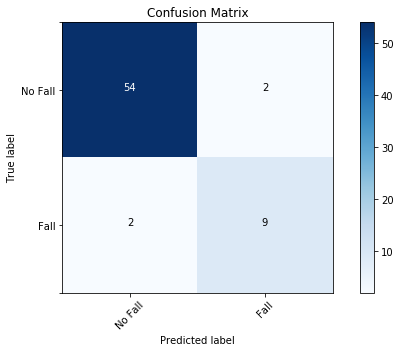

In [35]:
cm = confusion_matrix(Actuals, Predictions)
plot_confusion_matrix(cm, classes=['No Fall', 'Fall'], title="Confusion Matrix", figure_size=(8,5), save=0)

In [36]:
print('Test Accuracy: {:.2f}'.format(np.sum(Predictions==Actuals)/len(Actuals)))
print('Test Precision: {:.2f}'.format(precision_score(Actuals, Predictions)))
print('Test Recall: {:.2f}'.format(recall_score(Actuals, Predictions)))

Test Accuracy: 0.94
Test Precision: 0.82
Test Recall: 0.82


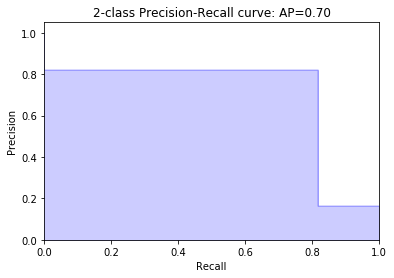

In [37]:
plot_prec_recall_curve(Predictions, Actuals)